# Experimental Models Mark IV and Plus: Linear (generally) Models

Only whatever that have worked for the baselines are to be tested. The 150 input features will likely make polynomial features (and thus, PCA) a stupid idea.

For reference:
- TSNV logit: f1-score \[0.63104 0.61646 0.46957 0.45263\] average 0.54243
- TSNV GAM: f1-score \[0.67984 0.65203 0.57895 0.46154\] average 0.59309


### Imports and reading the dataset

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int)
    return X, Y

dataset = pd.read_pickle('../Dataset/experimental_dataset_tsnv_24.gz')
# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 5633; Dev set size: 626; Testing set size: 696


### Tools

In [3]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report

In [4]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/experimental_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)
    
    # to load a model: model = joblib.load(filename)

In [5]:
# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [6]:
from scipy.special import expit

def regression_predict(regr, datasetX, method='clip'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='clip'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='clip'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [7]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.multioutput import MultiOutputRegressor, MultiOutputClassifier

def calibration_plot(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y;
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")  
    if isinstance(clf, MultiOutputRegressor):
        all_preds = regression_predict(clf, dataset_X)
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    for i in range(4):
        if isinstance(clf, MultiOutputClassifier):
            preds = all_preds[i,:,1]
        else:            
            preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    preds = np.array(clf.predict_proba(dataset_X)) if not isinstance(clf, MultiOutputRegressor) else regression_predict(clf, dataset_X)
    preds = preds[0,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,0]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = np.array(clf.predict_proba(dataset_X)) if not isinstance(clf, MultiOutputRegressor) else regression_predict(clf, dataset_X)
    preds = preds[3,:,1] if isinstance(clf, MultiOutputClassifier) else preds[:,3]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

### Linear models

Some improvement is observed, but the models do not converge.

LogisticRegression(max_iter=3000,C=0.5): average f1-score 0.55902      
LogisticRegression(max_iter=10000,C=0.5): average f1-score 0.56820       
LogisticRegression(max_iter=20000,C=0.5): average f1-score 0.56949       
LogisticRegression(max_iter=50000): average f1-score 0.56071       

Linear Regression: score 0.58693       
KNN Regressor (n_neighbors=5): score 0.62134       
KNN Regressor (n_neighbors=3): score 0.63257       
KNN Regressor (n_neighbors=2): score 0.63453    
KNN Regressor (n_neighbors=1): failed to converge

Nystroem (poly, degree=3) + SVM Regressor: score 0.56143       

In [18]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

basic_clf_1 = OneVsRestClassifier(LogisticRegression(
    max_iter=50000,
    verbose=0   
), n_jobs=-1)

basic_clf_1 = basic_clf_1.fit(train_X, train_Y)
print("Training accuracy: {0:.10f}".format(accuracy_score(train_Y, basic_clf_1.predict(train_X))))

# test model on dev set
preds = basic_clf_1.predict(dev_X)
acc = accuracy_score(dev_Y, preds)
print("Accuracy of classifier on dev set: {0:.10f}".format(acc))

print(classification_report(dev_Y, preds, zero_division=0))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

Training accuracy: 0.9167406355
Accuracy of classifier on dev set: 0.9025559105
              precision    recall  f1-score   support

           0       0.74      0.61      0.67        61
           1       0.62      0.64      0.63        39
           2       0.60      0.30      0.40        20
           3       0.71      0.26      0.38        19

   micro avg       0.68      0.53      0.59       139
   macro avg       0.67      0.45      0.52       139
weighted avg       0.68      0.53      0.58       139
 samples avg       0.06      0.06      0.05       139



Best Threshold=0.29681, F-Score=0.69630
Best Threshold=0.45578, F-Score=0.65854
Best Threshold=0.32624, F-Score=0.50000
Best Threshold=0.18242, F-Score=0.50000


/tmp/.u3556490/ipykernel_3082/2469156714.py:15: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
/tmp/.u3556490/ipykernel_3082/2469156714.py:15: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


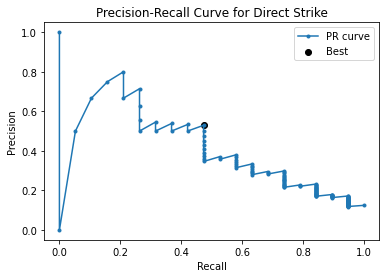

In [21]:
best_thresholds, best_f1_scores = optimize_thresholds(basic_clf_1, dev_X, dev_Y)

In [20]:
preds = predictions_with_thresholds(basic_clf_1, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.63014   0.75410   0.68657        61
           1    0.61905   0.66667   0.64198        39
           2    0.53333   0.40000   0.45714        20
           3    0.50000   0.42105   0.45714        19

   micro avg    0.60274   0.63309   0.61754       139
   macro avg    0.57063   0.56045   0.56071       139
weighted avg    0.59531   0.63309   0.60968       139
 samples avg    0.07002   0.07202   0.06709       139



In [22]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

linear_regr = MultiOutputRegressor(LinearRegression(), n_jobs=-1)
linear_regr = linear_regr.fit(train_X, train_Y)

Best Threshold=0.56023, F-Score=0.73504
Best Threshold=0.63331, F-Score=0.71642
Best Threshold=0.56169, F-Score=0.55000
Best Threshold=0.54717, F-Score=0.46667


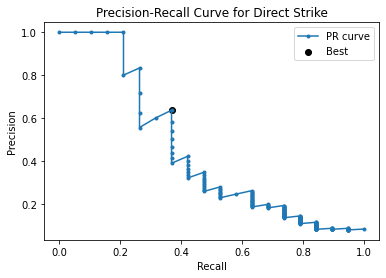

In [23]:
best_thresholds, best_f1_scores = regressor_find_thresholds(linear_regr, dev_X, dev_Y, 'sigmoid')

In [24]:
preds = regression_label(linear_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.76364   0.68852   0.72414        61
           1    0.85185   0.58974   0.69697        39
           2    0.52632   0.50000   0.51282        20
           3    0.60000   0.31579   0.41379        19

   micro avg    0.72973   0.58273   0.64800       139
   macro avg    0.68545   0.52351   0.58693       139
weighted avg    0.73187   0.58273   0.64369       139
 samples avg    0.06350   0.06456   0.06108       139



Best Threshold=0.73106, F-Score=0.60800
Best Threshold=0.73106, F-Score=0.66667
Best Threshold=0.73106, F-Score=0.63415
Best Threshold=0.73106, F-Score=0.47059


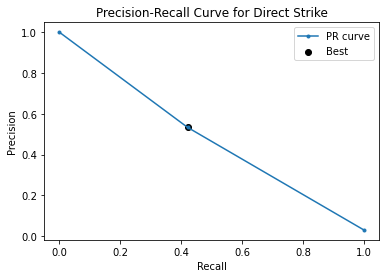

In [38]:
from sklearn.neighbors import KNeighborsRegressor

knr_regr = MultiOutputRegressor(KNeighborsRegressor(weights='distance', n_neighbors=1), n_jobs=-1)

knr_regr = knr_regr.fit(train_X, train_Y)
best_thresholds, best_f1_scores = regressor_find_thresholds(knr_regr, dev_X, dev_Y, 'sigmoid')

In [39]:
preds = regression_label(knr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000        61
           1    0.00000   0.00000   0.00000        39
           2    0.00000   0.00000   0.00000        20
           3    0.00000   0.00000   0.00000        19

   micro avg    0.00000   0.00000   0.00000       139
   macro avg    0.00000   0.00000   0.00000       139
weighted avg    0.00000   0.00000   0.00000       139
 samples avg    0.00000   0.00000   0.00000       139



In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

svr_regr = MultiOutputRegressor(LinearSVR(loss='squared_epsilon_insensitive', dual=False, C=0.5), n_jobs=-1)

pipe = make_pipeline(
    StandardScaler(),
    Nystroem(kernel='poly', degree=3),
    svr_regr, verbose=True
)
print(pipe)

poly_svr_regr = pipe.fit(train_X, train_Y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nystroem', Nystroem(degree=3, kernel='poly')),
                ('multioutputregressor',
                 MultiOutputRegressor(estimator=LinearSVR(C=0.5, dual=False,
                                                          loss='squared_epsilon_insensitive'),
                                      n_jobs=-1))],
         verbose=True)
[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.2s
[Pipeline] .......... (step 2 of 3) Processing nystroem, total=   0.2s
[Pipeline]  (step 3 of 3) Processing multioutputregressor, total=   0.6s


Best Threshold=0.57662, F-Score=0.70175
Best Threshold=0.56440, F-Score=0.68354
Best Threshold=0.53230, F-Score=0.44444
Best Threshold=0.52945, F-Score=0.51282


/tmp/.u3556490/ipykernel_3082/2953382678.py:28: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


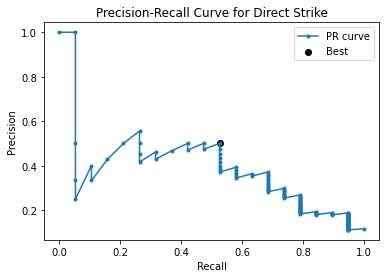

In [41]:
best_thresholds, best_f1_scores = regressor_find_thresholds(poly_svr_regr, dev_X, dev_Y, 'sigmoid')

In [42]:
preds = regression_label(poly_svr_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.75000   0.63934   0.69027        61
           1    0.66667   0.66667   0.66667        39
           2    0.33333   0.55000   0.41509        20
           3    0.47368   0.47368   0.47368        19

   micro avg    0.59441   0.61151   0.60284       139
   macro avg    0.55592   0.58242   0.56143       139
weighted avg    0.62890   0.61151   0.61445       139
 samples avg    0.05019   0.06323   0.05259       139



### GAM

This is quite easy to overfit, even though scores keep climbing with model complexity.

Everything as input, 20 splines: f1-score \[0.78333 **0.75000** 0.61538 0.57778\] average 0.68162     
40 splines for all: f1-score \[**0.80000** 0.71795 0.60000 0.62963\] average 0.68689  
60 splines for all: f1-score \[0.77273 0.74667 0.51429 0.61224\] average 0.66148  
40 splines, lam=1.2: 0.69420 (dev) vs 0.89513 (train)  
40, 1.8: 0.69684 vs 0.88985  
40, 2.4: 0.69893 vs 0.88682  
40, 2.6: \[0.79310 0.73418 **0.61538** **0.65306**\] 0.69893 vs 0.88616   
40, 2.8: 0.69893 vs 0.88423  
40, 3.0: 0.69604 vs 0.88252  
40, 4.2: 0.69452 vs 0.87807  

Best results: \[0.80000 0.75000 0.61538 0.65306\] average 0.70461

In [54]:
from pygam import LinearGAM, s, l, f, te

n_splines=40
lam=2.6
terms = s(0, n_splines=n_splines, lam=lam)
for i in range(1,149):
    terms += s(i, n_splines=n_splines, lam=lam)

gams = []
for i in range(4):
    gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(train_X, train_Y[:,i])
    print(gam.summary())
    gams.append(gam)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1076.4194
Link Function:                     IdentityLink Log Likelihood:                                -54670.3246
Number of Samples:                         5633 AIC:                                           111495.4881
                                                AICc:                                          112005.7041
                                                GCV:                                                  0.05
                                                Scale:                                              0.0332
                                                Pseudo R-Squared:                                   0.7151
Feature Function                  Lam

/tmp/.u3556490/ipykernel_24354/174568684.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1076.4194
Link Function:                     IdentityLink Log Likelihood:                                -73462.8435
Number of Samples:                         5633 AIC:                                           149080.5257
                                                AICc:                                          149590.7417
                                                GCV:                                                0.0386
                                                Scale:                                              0.0256
                                                Pseudo R-Squared:                                   0.6851
Feature Function                  Lam

/tmp/.u3556490/ipykernel_24354/174568684.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1076.4194
Link Function:                     IdentityLink Log Likelihood:                               -125840.8539
Number of Samples:                         5633 AIC:                                           253836.5465
                                                AICc:                                          254346.7625
                                                GCV:                                                0.0239
                                                Scale:                                              0.0158
                                                Pseudo R-Squared:                                   0.5578
Feature Function                  Lam

/tmp/.u3556490/ipykernel_24354/174568684.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1076.4194
Link Function:                     IdentityLink Log Likelihood:                               -176649.0056
Number of Samples:                         5633 AIC:                                             355452.85
                                                AICc:                                           355963.066
                                                GCV:                                                0.0175
                                                Scale:                                              0.0116
                                                Pseudo R-Squared:                                    0.457
Feature Function                  Lam

/tmp/.u3556490/ipykernel_24354/174568684.py:12: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [55]:
raw_preds = [model.predict(dev_X) for model in gams]
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

(626, 4)


Best Threshold=0.43895, F-Score=0.80342
Best Threshold=0.46131, F-Score=0.75000
Best Threshold=0.31858, F-Score=0.65000
Best Threshold=0.18143, F-Score=0.68000


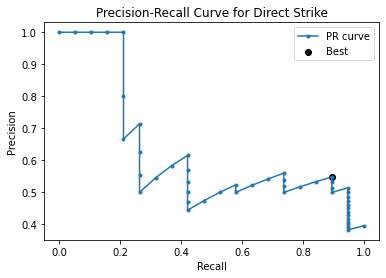

In [56]:
best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

In [57]:
preds = []
# iterate each predicted probability and compare against threshold
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

              precision    recall  f1-score   support

           0    0.83636   0.75410   0.79310        61
           1    0.72500   0.74359   0.73418        39
           2    0.63158   0.60000   0.61538        20
           3    0.53333   0.84211   0.65306        19

   micro avg    0.71528   0.74101   0.72792       139
   macro avg    0.68157   0.73495   0.69893       139
weighted avg    0.73423   0.74101   0.73186       139
 samples avg    0.07149   0.07668   0.07024       139



In [58]:
# training set
# scoring step
raw_preds = []
for i in range(4):
    preds = expit(gams[i].predict(train_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(train_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(train_Y, preds, digits=5, zero_division=0))

(5633, 4)
              precision    recall  f1-score   support

           0    0.90296   0.92580   0.91424       593
           1    0.88471   0.88471   0.88471       399
           2    0.86127   0.88690   0.87390       168
           3    0.88542   0.85859   0.87179        99

   micro avg    0.89028   0.90230   0.89625      1259
   macro avg    0.88359   0.88900   0.88616      1259
weighted avg    0.89023   0.90230   0.89616      1259
 samples avg    0.09802   0.10024   0.09738      1259



### Poisson GAM

The data is assumed to have Poisson distribution. It apparently needs different regularization strengths for different targets in order to converge.

With lam = \[0.6, 0.6, 6.0, 6.0\] and 20 splines for all features: f1-score \[0.80000 0.75000 0.74419 0.68293\] average 0.74428  

Compare original: \[0.80000 0.75000 0.61538 0.65306\] average 0.70461  
Compare best so far: \[0.82353 0.72464 0.74419 0.75676\] average 0.76228

In [21]:
from pygam import PoissonGAM, s

gams = []
for i in range(4):
    lam = 0.6 if i < 2 else 6.0
    terms = s(0, lam=lam, n_splines=20)
    for j in range(1,149):
        terms += s(j, lam=lam, n_splines=20)
    
    gam = PoissonGAM(terms, max_iter=1000, verbose=True).fit(train_X, train_Y[:,i])
    print(gam.summary())
    gams.append(gam)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                    397.6754
Link Function:                          LogLink Log Likelihood:                                   -774.644
Number of Samples:                         5633 AIC:                                              2344.639
                                                AICc:                                            2405.5336
                                                UBRE:                                               2.2622
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8639
Feature Function                  Lam

/tmp/.u3556490/ipykernel_9780/1088191441.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                    349.7016
Link Function:                          LogLink Log Likelihood:                                  -500.1142
Number of Samples:                         5633 AIC:                                             1699.6315
                                                AICc:                                            1746.3406
                                                UBRE:                                               2.2097
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.9043
Feature Function                  Lam

/tmp/.u3556490/ipykernel_9780/1088191441.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     171.381
Link Function:                          LogLink Log Likelihood:                                  -239.6755
Number of Samples:                         5633 AIC:                                              822.1131
                                                AICc:                                             833.0617
                                                UBRE:                                               2.1106
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8785
Feature Function                  Lam

/tmp/.u3556490/ipykernel_9780/1088191441.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                    139.1553
Link Function:                          LogLink Log Likelihood:                                  -139.8349
Number of Samples:                         5633 AIC:                                              557.9804
                                                AICc:                                             565.1851
                                                UBRE:                                               2.0837
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8979
Feature Function                  Lam

/tmp/.u3556490/ipykernel_9780/1088191441.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


(626, 4)
Best Threshold=0.18386, F-Score=0.80882
Best Threshold=0.26756, F-Score=0.76543
Best Threshold=0.18301, F-Score=0.77273
Best Threshold=0.08721, F-Score=0.71429
              precision    recall  f1-score   support

           0    0.72973   0.88525   0.80000        61
           1    0.73171   0.76923   0.75000        39
           2    0.69565   0.80000   0.74419        20
           3    0.63636   0.73684   0.68293        19

   micro avg    0.71250   0.82014   0.76254       139
   macro avg    0.69836   0.79783   0.74428       139
weighted avg    0.71262   0.82014   0.76194       139
 samples avg    0.08400   0.08786   0.08258       139



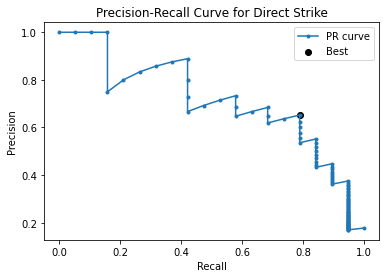

In [22]:
raw_preds = [model.predict(dev_X) for model in gams]
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

plt.plot(recall, precision, marker='.', label='PR curve')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Direct Strike')
plt.legend()

preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

#### Tree-based feature selection

Sadly XGBoost OOM'd on this (the 110000+ polynomial features!). ExtraTrees was introduced to be the source of feature importances instead. The initializations will be different each time, so will the chosen features.

With 12 best polynomial features chosen, the f1-score for target 0 is 0.70796, which wasn't as good as before. It also failed to converge for target 3.  
Best 100 features yielded 0.63333 for target 0, but 200 gave 0.77064. Taking into account that the GAM can take about 13000 splines without OOM, max #features possible is about 650. 300 did not converge, but 250 did. Here are some extra testings:

From all poly,  
K=300: f1-score \[0.78788 0.76190 0.45283 0.62222\] average 0.65621 (train set 0.80455)  
K=275: f1-score \[0.79310 0.73973 0.51852 0.51163\] average 0.64074 (train set 0.78486)   
K=250: f1-score \[0.79032 0.69841 0.60606 0.58065\] average 0.66886 (train set 0.79185); unstable results    
K=225: f1-score \[0.74016 0.76056 0.48276 0.53061\] average 0.62852 (train set 0.77227)  
K=200: f1-score \[0.75630 0.70769 0.58824 0.56250\] average 0.65368 (train set 0.74870)  
K=150: f1-score \[0.78333 **0.77143** 0.55556 0.44776\] average 0.63952 (train set 0.68451)  

K=275 (with power terms): f1-score \[0.76259 0.67647 0.54054 0.63636\] average 0.65399   
K=250 (with power terms): f1-score \[0.75000 0.72222 0.56250 0.51852\] average 0.63831  
K=225 (with power terms): f1-score \[0.74510 0.70588 0.54545 0.56522\] average 0.64041  
K=200 (with power terms): f1-score \[0.73786 0.70588 0.55556 0.53659\] average 0.63397   
K=150 (with power terms): f1-score \[0.76636 0.71642 0.50000 0.42553\] average 0.60208  

K=150, n_splines=40: f1-score \[0.76786 0.74627 0.57143 0.48649\] average 0.64301  
K=150, lam=1.2: f1-score \[0.77966 0.77143 0.55556 0.45714\] average 0.64095  
K=150, lam=1.8: f1-score \[0.77966 0.77143 0.57143 0.45714\] average 0.64492  

K=275, lam=1.2: f1-score \[0.77586 0.73973 0.51852 0.50000\] average 0.63353

Compare original: f1-score \[**0.80000** 0.75000 **0.61538** **0.65306**\] average 0.70461  

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import ExtraTreesClassifier
from pygam import LinearGAM, s
from scipy.special import expit

# modify data
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
transformed_X = poly.fit_transform(train_X)

all_sfms = []
all_gams = []
K = 225
lam = 0.6
n_splines=20

terms = s(0, lam=lam, n_splines=n_splines)
for i in range(1,K):
    terms += s(i, lam=lam, n_splines=n_splines)

for i in range(4):
    # build tree to select
    clf = ExtraTreesClassifier(random_state=42).fit(transformed_X, train_Y[:,i])
    sfm = SelectFromModel(estimator=clf, max_features=K, prefit=True)
    # print(clf.score(transformed_X, train_Y[:,i]))
    all_sfms.append(sfm)

    # see which ones are they
    # mask = sfm.get_support()
    # names = poly.get_feature_names_out()
    # scores = sfm.estimator.feature_importances_
    # importance = np.stack([names[mask], scores[mask]], axis=1)
    # print(importance[np.argsort(importance[:,1])])

    sfm_X = sfm.transform(transformed_X)
    gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(sfm_X, train_Y[:,i])
    print(gam.summary())
    all_gams.append(gam)
    
# scoring step
raw_preds = []
for i in range(4):
    tr_dev_X = all_sfms[i].transform(poly.transform(dev_X))
    preds = expit(all_gams[i].predict(tr_dev_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    616.4145
Link Function:                     IdentityLink Log Likelihood:                                -73021.3994
Number of Samples:                         5633 AIC:                                           147277.6276
                                                AICc:                                          147429.9106
                                                GCV:                                                0.0354
                                                Scale:                                              0.0285
                                                Pseudo R-Squared:                                   0.7301
Feature Function                  Lam

/tmp/.u3556490/ipykernel_10013/2671077190.py:37: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    342.9458
Link Function:                     IdentityLink Log Likelihood:                                -76089.6156
Number of Samples:                         5633 AIC:                                           152867.1227
                                                AICc:                                          152911.9946
                                                GCV:                                                0.0327
                                                Scale:                                              0.0291
                                                Pseudo R-Squared:                                   0.5845
Feature Function                  Lam

/tmp/.u3556490/ipykernel_10013/2671077190.py:37: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    337.5478
Link Function:                     IdentityLink Log Likelihood:                               -176354.3416
Number of Samples:                         5633 AIC:                                           353385.7787
                                                AICc:                                          353429.2109
                                                GCV:                                                0.0152
                                                Scale:                                              0.0135
                                                Pseudo R-Squared:                                   0.5598
Feature Function                  Lam

/tmp/.u3556490/ipykernel_10013/2671077190.py:37: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    637.3465
Link Function:                     IdentityLink Log Likelihood:                               -228715.7954
Number of Samples:                         5633 AIC:                                           458708.2839
                                                AICc:                                          458871.7413
                                                GCV:                                                0.0125
                                                Scale:                                                0.01
                                                Pseudo R-Squared:                                   0.4857
Feature Function                  Lam

/tmp/.u3556490/ipykernel_10013/2671077190.py:37: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


(626, 4)
              precision    recall  f1-score   support

           0    0.92683   0.62295   0.74510        61
           1    0.82759   0.61538   0.70588        39
           2    0.69231   0.45000   0.54545        20
           3    0.48148   0.68421   0.56522        19

   micro avg    0.76364   0.60432   0.67470       139
   macro avg    0.73205   0.59314   0.64041       139
weighted avg    0.80437   0.60432   0.68078       139
 samples avg    0.06962   0.06470   0.06282       139



In [14]:
del all_gams, all_sfms, poly, transformed_X, preds, raw_preds

In [27]:
# training set
# scoring step
raw_preds = []
for i in range(4):
    tr_dev_X = all_sfms[i].transform(poly.transform(train_X))
    preds = expit(all_gams[i].predict(tr_dev_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(train_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(train_Y, preds, digits=5, zero_division=0))

(5633, 4)
              precision    recall  f1-score   support

           0    0.88007   0.87858   0.87932       593
           1    1.00000   0.54135   0.70244       399
           2    0.79286   0.66071   0.72078       168
           3    0.93023   0.80808   0.86486        99

   micro avg    0.89749   0.73709   0.80942      1259
   macro avg    0.90079   0.72218   0.79185      1259
weighted avg    0.91038   0.73709   0.80097      1259
 samples avg    0.09819   0.08493   0.08866      1259



#### Mutual-information based feature selection

Let's hope this doesn't OOM. Btw, the features chosen do not seem to be very consistent. Here is a roughly organized list of tested configurations:  

top 125 features (generated from 30 original), f1-score \[0.77311 0.70270 0.54545 0.68085\] average 0.67553  
top 113 from 30, f1-score \[0.77311 0.72000 0.52381 0.54545\] average 0.64059  
top 137 from 30, f1-score \[0.75714 0.70588 0.63158 0.71111\] average 0.70143    
top 150 features, f1-score \[0.76364 0.69565 0.50000 0.71111\] average 0.66760    

top 125 features from 60 original, f1-score \[0.66667 0.61538 0.55000 0.47619\] average 0.57706  
top 150 from 60: f1-score \[0.71724 0.65753 0.64706 0.50847\] average 0.63258   
top 175 from 60: f1-score \[0.73381 0.67500 0.55172 0.55556\] average 0.62902  
top 200 from 60: f1-score \[0.73469 0.69136 0.55172 0.44444\] average 0.60556  
probably there is still a long way to go to match that of top-n-from-30.

K=137, N=1, w/ powers, f1-score \[0.77778 0.68966 0.63636 0.52941\] average 0.65830  
K=137, N=1, w/ powers, n_splines=40: f1-score \[0.79279 0.66667 0.66667 0.56250\] average 0.67216   
K=137, N=1, w/ powers, n_splines=60: f1-score \[**0.82353** 0.65934 0.66667 0.57143\] average 0.68024  
K=150, N=2, w/ powers, f1-score \[0.70769 0.66667 0.60000 0.47826\] average 0.61315  
K=150, N=2, w/ powers, n_splines=20, lam=1.2: f1-score \[0.70400 0.65714 0.55814 0.47826\] average 0.59939  

K=137, N=1, n_splines=40: f1-score \[0.77966 0.70588 0.62500  0.71111\] average 0.70541   
K=137, N=1, n_splines=60: f1-score \[0.80315 0.69663 0.55556 **0.75556**\] average 0.70272  
K=137, N=1, n_splines=80: f1-score \[0.79339 0.70968 0.57143 0.75000\] average 0.70612  
K=137, N=1, n_splines=20, lam=1.2: f1-score \[0.75714 0.70330 0.61538 0.71111\] average 0.69673  
K=137, N=1, n_splines=20, lam=0.9: f1-score \[0.75714 0.71111 0.63158 0.71111\] average 0.70274  
K=137, N=1, n_splines=20, lam=0.3: f1-score \[0.74453 0.72464 0.58065 0.73913\] average 0.69723  

K=150, N=2, n_splines=40: f1-score \[0.75000 0.63415 0.57895 0.40000\] average 0.59077  
K=150, N=2, n_splines=20, lam=1.2: f1-score \[0.71756 0.65753 0.62857 0.52632\] average 0.63249  
K=150, N=2, n_splines=20, lam=1.8: f1-score \[0.71318 0.64103 0.61111 0.51282\] average 0.61953  
K=150, N=2, n_splines=20, lam=0.3: f1-score \[0.73103 0.65714 0.60606 0.48276\] average 0.61925
    
Linear, K=100, N=1, w/ powers, n_splines=60, lam=\[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.80328 0.69474 0.75676 0.68571\] average 0.73512   
Linear, K=125, N=1, w/ powers, n_splines=60, lam=\[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.81203 0.79121 0.73171 0.68421\] average 0.75479  
Linear, K=137, N=1, w/powers, n_splines=40, lam=\[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.79279 0.77419 **0.76923** 0.70270\] average 0.75973  
Linear, K=137, N=1, w/powers, n_splines=60, lam=\[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.82353 0.79070 0.75676 0.68571\] average 0.76417    
Linear, K=137, N=1, w/o powers, n_splines=60, lam=\[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.80315 0.78261 0.72222 0.75556\] average **0.76588**   
Linear, K=150, N=1, w/ powers, n_splines=60, lam=\[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.80597 0.80460 0.76923 0.74286\] average 0.78066  
Poisson, K=137, N=1, w/o powers, n_splines=20, lam=\[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.80303 **0.82927** 0.75000 0.66667\] average 0.76224  
Other configurations don't converge in reasonable time.
  
CV could be used to get more precise estimates.

Compare original: f1-score \[0.80000 0.75000 0.61538 0.65306\] average 0.70461  

If we greedily choose the best GAMs for the four targets separately, then we can a pretty solid f1-score for linear models.

In [14]:
print(list(train_X.columns))

['MM00', 'DD00', 'MI_STATUS00', 'LI_STATUS00', 'SI_STATUS00', 'DS_STATUS00', 'DIST00', 'AZM00', 'SPEED00', 'DIR00', 'VMAX00', 'DVMAX00', 'ULVWS00', 'MLVWS00', 'HI_HUMID00', 'LO_HUMID00', 'STEMP00', 'UTEMP00', 'U_HK00', 'V_HK00', 'U20000', 'U50000', 'V50000', 'EASM00', 'VORT00', 'WESTERLY00', 'SH_AREA00', 'SH_INT00', 'SH_EXT00', 'POTT00', 'MM06', 'DD06', 'MI_STATUS06', 'LI_STATUS06', 'SI_STATUS06', 'DS_STATUS06', 'DIST06', 'AZM06', 'SPEED06', 'DIR06', 'VMAX06', 'DVMAX06', 'ULVWS06', 'MLVWS06', 'HI_HUMID06', 'LO_HUMID06', 'STEMP06', 'UTEMP06', 'U_HK06', 'V_HK06', 'U20006', 'U50006', 'V50006', 'EASM06', 'VORT06', 'WESTERLY06', 'SH_AREA06', 'SH_INT06', 'SH_EXT06', 'POTT06', 'MM12', 'DD12', 'MI_STATUS12', 'LI_STATUS12', 'SI_STATUS12', 'DS_STATUS12', 'DIST12', 'AZM12', 'SPEED12', 'DIR12', 'VMAX12', 'DVMAX12', 'ULVWS12', 'MLVWS12', 'HI_HUMID12', 'LO_HUMID12', 'STEMP12', 'UTEMP12', 'U_HK12', 'V_HK12', 'U20012', 'U50012', 'V50012', 'EASM12', 'VORT12', 'WESTERLY12', 'SH_AREA12', 'SH_INT12', 'SH_

In [8]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from pygam import LinearGAM, s, PoissonGAM
from scipy.special import expit
from functools import partial

N_STEPS = 1
K = 137
lam = [0.6, 0.6, 6.0, 0.6]
n_splines=60
power_terms = False
all_fs = []
all_gams = []

# poly generation step
poly = PolynomialFeatures(degree=3, interaction_only=(not power_terms), include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:(30*N_STEPS)])

for i in range(4):  
    terms = s(0, lam=lam[i], n_splines=n_splines)
    for j in range(1,K):
        terms += s(j, lam=lam[i], n_splines=n_splines)
        
    # feature selection step
    fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=K)
    fs.fit(transformed_X, train_Y[:,i])
    fs_X = fs.transform(transformed_X)
    all_fs.append(fs)
    
    # GAM fitting step           
    gam = LinearGAM(terms,max_iter=1000, verbose=True).fit(fs_X, train_Y[:,i])
    print(gam.summary())
    all_gams.append(gam)
        
# scoring step
raw_preds = []
for i in range(4):
    tr_dev_X = all_fs[i].transform(poly.transform(dev_X.iloc[:,:(30*N_STEPS)]))
    # preds = expit(all_gams[i].predict(tr_dev_X))
    preds = np.clip(all_gams[i].predict(tr_dev_X), 0, 1)
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1270.4336
Link Function:                     IdentityLink Log Likelihood:                                -46556.0853
Number of Samples:                         5633 AIC:                                            95655.0378
                                                AICc:                                           96397.0583
                                                GCV:                                                0.0601
                                                Scale:                                              0.0363
                                                Pseudo R-Squared:                                   0.7014
Feature Function                  Lam

/tmp/.u3556490/ipykernel_5347/1400410589.py:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1880.5104
Link Function:                     IdentityLink Log Likelihood:                                -53943.2171
Number of Samples:                         5633 AIC:                                            111649.455
                                                AICc:                                          113538.2552
                                                GCV:                                                0.0638
                                                Scale:                                              0.0272
                                                Pseudo R-Squared:                                   0.7251
Feature Function                  Lam

/tmp/.u3556490/ipykernel_5347/1400410589.py:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1140.0183
Link Function:                     IdentityLink Log Likelihood:                               -111432.2163
Number of Samples:                         5633 AIC:                                           225146.4691
                                                AICc:                                          225726.7715
                                                GCV:                                                 0.027
                                                Scale:                                              0.0174
                                                Pseudo R-Squared:                                   0.5202
Feature Function                  Lam

/tmp/.u3556490/ipykernel_5347/1400410589.py:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2044.6391
Link Function:                     IdentityLink Log Likelihood:                               -169146.3168
Number of Samples:                         5633 AIC:                                           342383.9117
                                                AICc:                                          344718.6935
                                                GCV:                                                0.0248
                                                Scale:                                              0.0094
                                                Pseudo R-Squared:                                    0.652
Feature Function                  Lam

/tmp/.u3556490/ipykernel_5347/1400410589.py:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


(626, 4)
              precision    recall  f1-score   support

           0    0.77273   0.83607   0.80315        61
           1    0.67925   0.92308   0.78261        39
           2    0.81250   0.65000   0.72222        20
           3    0.77778   0.73684   0.75676        19

   micro avg    0.74510   0.82014   0.78082       139
   macro avg    0.76056   0.78650   0.76618       139
weighted avg    0.75291   0.82014   0.77940       139
 samples avg    0.08187   0.08320   0.08009       139



### Construction of finalized GAMs

Target 0: Linear, K=137, N=1, w/powers, n_splines=60      
Target 1: Poisson, K=137, N=1, w/o powers, n_splines=20   
Target 2: Linear, K=137, N=1, w/powers, n_splines=40, lam=6.0     
Target 3: Linear, K=137, N=1, w/o powers: n_splines=60

A sad thing is that this guy doesn't support calibration. The mediocre performance may be reflected in the calibration plot - most of the predicted probabilities are around 0.5 (which is arguably what a sensible regressor would end up doing).

In [9]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from pygam import PoissonGAM, s, LinearGAM
from scipy.special import expit
from functools import partial

model = dict()
all_poly = []
all_fs = []
all_gams = []
all_input_feature_count = [30, 30, 30, 30]

# target 0: Linear, K=137, N=1, w/powers, n_splines=60, lam=[0.6, 0.6, 6.0, 6.0]
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:30])
all_poly.append(poly)

fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=137)
fs.fit(transformed_X, train_Y[:,0])
all_fs.append(fs)

terms = s(0, lam=0.6, n_splines=60)
for i in range(1,137):
    terms += s(i, lam=0.6, n_splines=60)
fs_X = fs.transform(transformed_X)
gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(fs_X, train_Y[:,0])
print(gam.summary())
all_gams.append(gam)

# target 1: Poisson, K=137, N=1, w/o powers, n_splines=20, lam=[0.6, 0.6, 6.0, 6.0]
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:30])
all_poly.append(poly)

fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=137)
fs.fit(transformed_X, train_Y[:,1])
all_fs.append(fs)

terms = s(0, lam=0.6, n_splines=20)
for i in range(1,137):
    terms += s(i, lam=0.6, n_splines=20)
    
fs_X = fs.transform(transformed_X)
gam = PoissonGAM(terms, max_iter=1000, verbose=True).fit(fs_X, train_Y[:,1])
print(gam.summary())
all_gams.append(gam)

# target 2: Linear, K=137, N=1, w/powers, n_splines=40, lam=[0.6, 0.6, 6.0, 6.0]
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:30])
all_poly.append(poly)

fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=137)
fs.fit(transformed_X, train_Y[:,2])
all_fs.append(fs)

terms = s(0, lam=6.0, n_splines=40)
for i in range(1,137):
    terms += s(i, lam=6.0, n_splines=40)
    
fs_X = fs.transform(transformed_X)
gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(fs_X, train_Y[:,2])
print(gam.summary())
all_gams.append(gam)

# target 3: Top k=137 from 30 input features' polynomials (no power terms), 60 splines 
poly = PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:30])
all_poly.append(poly)

fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=137)
fs.fit(transformed_X, train_Y[:,3])
all_fs.append(fs)

terms = s(0, lam=0.6, n_splines=60)
for i in range(1,137):
    terms += s(i, lam=0.6, n_splines=60)
    
fs_X = fs.transform(transformed_X)
gam = LinearGAM(terms, max_iter=1000, verbose=True).fit(fs_X, train_Y[:,3])
print(gam.summary())
all_gams.append(gam)

model["poly"] = all_poly
model["fs"] = all_fs
model["gam"] = all_gams
model["input_feature_count"] = all_input_feature_count

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    1538.581
Link Function:                     IdentityLink Log Likelihood:                                -43503.8258
Number of Samples:                         5633 AIC:                                            90086.8136
                                                AICc:                                           91245.9565
                                                GCV:                                                0.0684
                                                Scale:                                              0.0359
                                                Pseudo R-Squared:                                   0.7232
Feature Function                  Lam

/tmp/.u3556490/ipykernel_5347/694452931.py:27: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                    257.6291
Link Function:                          LogLink Log Likelihood:                                  -523.4708
Number of Samples:                         5633 AIC:                                             1562.1999
                                                AICc:                                            1587.1927
                                                UBRE:                                               2.1723
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.8822
Feature Function                  Lam

/tmp/.u3556490/ipykernel_5347/694452931.py:45: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1165.5115
Link Function:                     IdentityLink Log Likelihood:                               -111211.4574
Number of Samples:                         5633 AIC:                                           224755.9377
                                                AICc:                                          225365.9115
                                                GCV:                                                0.0272
                                                Scale:                                              0.0173
                                                Pseudo R-Squared:                                   0.5249
Feature Function                  Lam

/tmp/.u3556490/ipykernel_5347/694452931.py:63: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   2044.6391
Link Function:                     IdentityLink Log Likelihood:                               -169146.3168
Number of Samples:                         5633 AIC:                                           342383.9117
                                                AICc:                                          344718.6935
                                                GCV:                                                0.0248
                                                Scale:                                              0.0094
                                                Pseudo R-Squared:                                    0.652
Feature Function                  Lam

/tmp/.u3556490/ipykernel_5347/694452931.py:81: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [11]:
# scoring step
raw_preds = []
for i in range(4):
    in_dev_X = model["poly"][i].transform(dev_X.iloc[:,:(model["input_feature_count"][i])])
    tr_dev_X = model["fs"][i].transform(in_dev_X)
    # preds = expit(model["gam"][i].predict(tr_dev_X))
    preds = np.clip(model["gam"][i].predict(tr_dev_X), 0, 1)
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds = []
best_f1_scores = []
for i in range(4):
    precision, recall, thresholds = precision_recall_curve(dev_Y[:,i], raw_preds[:,i])
    # find best threshold
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.nanargmax(fscore)
    best_thresholds.append(thresholds[ix])
    best_f1_scores.append(fscore[ix])
    
preds = []
for i in range(len(raw_preds)):
    pred_row = []
    for j in range(4):
        if raw_preds[i,j] > best_thresholds[j]:
            pred_row.append(1)
        else:
            pred_row.append(0)
    preds.append(pred_row)
preds = np.array(preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

(626, 4)
              precision    recall  f1-score   support

           0    0.74667   0.91803   0.82353        61
           1    0.79070   0.87179   0.82927        39
           2    0.78947   0.75000   0.76923        20
           3    0.77778   0.73684   0.75676        19

   micro avg    0.76774   0.85612   0.80952       139
   macro avg    0.77615   0.81917   0.79470       139
weighted avg    0.76943   0.85612   0.80820       139
 samples avg    0.08919   0.08826   0.08616       139



(626, 4)
Brier score losses: (the smaller the better)
Class 0, no calibration: 0.034612
Class 1, no calibration: 0.016746
Class 2, no calibration: 0.014654
Class 3, no calibration: 0.014619


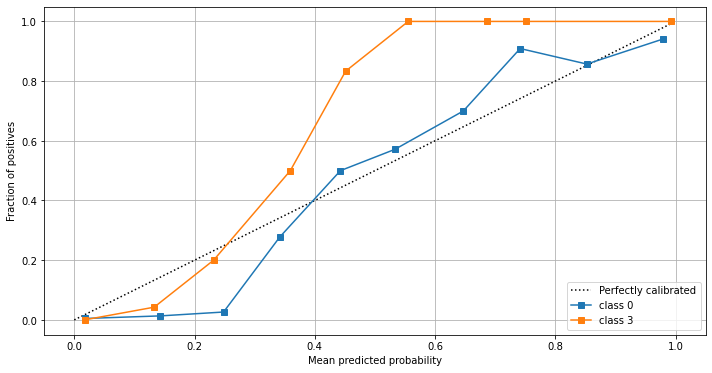

In [12]:
# check whether the calibration is good
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec
from sklearn.neural_network import MLPClassifier

#generate predictions
raw_preds = []
for i in range(4):
    in_dev_X = model["poly"][i].transform(dev_X.iloc[:,:(model["input_feature_count"][i])])
    tr_dev_X = model["fs"][i].transform(in_dev_X)
    # preds = expit(model["gam"][i].predict(tr_dev_X))
    preds = np.clip(model["gam"][i].predict(tr_dev_X), 0, 1)
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

# brier score loss
print("Brier score losses: (the smaller the better)")    
for i in range(4):
    preds = raw_preds[:,i]
    clf_score = brier_score_loss(dev_Y[:,i], preds)
    print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

# plot calibration graphs
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
ax = fig.add_subplot(gs[:2, :2])

preds = raw_preds[:,0]
display = CalibrationDisplay.from_predictions(dev_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
preds = raw_preds[:,3]
display = CalibrationDisplay.from_predictions(dev_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

ax.grid()
plt.tight_layout()
plt.show()

In [13]:
# save to file
import pickle as pk
from datetime import datetime

pk.dump(model, open("./models/experimental_model_gam_tsnv_{}.pkl".format(str(datetime.now().strftime("%Y-%m-%d %H-%M"))), 'wb'))